# Locating minimal surface mass balance over the East Antarctic Plateau -  a showcase of simple 2D Bayesian Optimisation

# Introduction

This notebook is created to showcase a simple application of Bayesian Optimisation (BO) to surface mass balance data (abbreviated as **smb** in the following).

Objective: 
Find location with lowest long-term average smb over the East Antarctic Plateau. 
(39-year-average)

### Data

- **RACMO2.3p3 ANT27 data** 
    - key publication: [van Dalum et al. 2022](10.5194/egusphere-egu22-12543)
    - data downloadable from [zenodo](https://zenodo.org/record/5512077#.Y-BERuxBwvo)
    - file: `smb_monthlyS_ANT27_CONsettings_197901_201812.nc` ; (CON stands for Control run)
    - an overview of model versions and meta data is available on the [Institute for Marine and Atmospheric research Utrecht (IMAU) website](https://www.projects.science.uu.nl/iceclimate/models/racmo-data.php)
    - a description of model updates is available under the following section of the [Institute for Marine and Atmospheric research Utrecht (IMAU) website](https://www.projects.science.uu.nl/iceclimate/models/racmo-model.php#1-2)
        
- the previous version of this Regional Climate Model: RACMO2.3p2 ANT27 data 
    - data available from [Utrecht University server](https://www.projects.science.uu.nl/iceclimate/publications/data/2018/vwessem2018_tc/RACMO_Yearly/)
    - I requested 2 km downscaled smb data from RACMO2.3p2 (stereographic projection) from [Dr Brice Noël](https://scholar.google.be/citations?user=MnrZh5wAAAAJ&hl=en)

### Units
Surface Mass Balance (**smb**) is reported in millimeters of water equivalent (w.e.) per year [$ \text{mm w.e. }yr^{-1}$], which is equivalent to kg per m^(–2) per year [$ \text{kg }m^{-2} yr^{-1}$]. See key publication for more information.

### Projections
- The gridded/lattice smb data from RACMO2.3p3 ANT27 is provided using a **Rotated Pole projection**. 
- I am converting inputs to the [EPSG:3031](https://epsg.io/3031) **WGS 84 / Antarctic Polar Stereographic projection**, one of the two dominant gridded map projections used for Antarctic Science. The [National Snow and Ice Data Center (NSIC) website](https://nsidc.org/data/user-resources/help-center/what-are-polar-stereographic-and-ease-grid-projections-which-one-should-i-use) provides more information on the Polar Stereographic projection and also the EASE-Grid 2.0, a family of equal-area projections. Polar Stereographic is choosen here because the vast about of input data is provided in this form.

## Problem setting


### Inputs

We only use the 2D coordinates as inputs. We stick to the BoTorch variables naming conventions where x are inputs and y is the target values. Thus longitude - normally the x-axis - corresponds to `x1` and latitude - normally the y-axis - corresponds to `x2`.

# Code

In [1]:
# load packages
import xarray as xr
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.path as mpath # for circular boundry
import matplotlib.patches as patches # for selected area
import matplotlib.colors as colors

# cartopy: Coordinate Reference System (list of projections)
import cartopy
# common abbreviation
import cartopy.crs as ccrs
import cartopy.feature as cfe

# Projections between CRSs (Coordinate Reference Systems)
import pyproj
import shapely
from pyproj import Proj, transform

import gpytorch
import torch
import GPy 

from botorch.models import SingleTaskGP, ModelListGP
# Gpytorch is a dependency of BoTorch
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.optim import optimize_acqf

# Inline interactive vis properties in Jupyter lab
%matplotlib ipympl
%matplotlib inline

# Reproducibility
import watermark

/Users/kimbente/opt/anaconda3/envs/py3.9/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Load data

To reproduce this notebook locally, download the data as specified above and change the path below to match your file location.

In [2]:
# change this to your path
full_path = "/Users/kimbente/Desktop/Bayesian Optimisation/BO-ANT-project/raw-data/RACMO2.3p3/CON_data/smb_monthlyS_ANT27_CONsettings_197901_201812.nc"

# Open nc file as xarray dataset
ds = xr.open_dataset(full_path)

## Preprocess

In [3]:
# PREPROCESSING IN XARRAY
def preprocess_racmo_xr(dataset_xr):
    """
    Wrapping preprocessing operations including projection into one function.
    Input: xarray data set
    Output: xarray data set
    """
    # remove height as dimension and as coordinate because it is redundant
    dataset_xr_clean = dataset_xr.drop_vars('height').squeeze()
    # extract smb variable and take mean over all available years
    # type needs to be xarray.Dataset to have explicit dimensions
    dataset_smb_xr = dataset_xr_clean["smb"].mean("time").to_dataset()
    
    # PROJECTION
    # define projection from rotated pole to APS
    # always x y or lon lat order
    rotatedpole_to_APS71_func = pyproj.Transformer.from_crs(crs_from = pyproj.CRS("-m 57.295779506 +proj=ob_tran +o_proj=latlon +o_lat_p=-180.0 +lon_0=10.0"),  
                                                  crs_to = pyproj.CRS("+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs"), 
                                                  always_xy = True)
    # create meshgrid from rotated_pole grid
    rlon_2d, rlat_2d = np.meshgrid(dataset_smb_xr.rlon.values, dataset_smb_xr.rlat.values)
    # transform points
    x1_2d, x2_2d = rotatedpole_to_APS71_func.transform(rlon_2d, rlat_2d)
    # add as coordinates to to xarray
    dataset_smb_xr.coords['x1_2d'] = (dataset_smb_xr.coords["lon"].dims, x1_2d)
    dataset_smb_xr.coords['x2_2d'] = (dataset_smb_xr.coords["lat"].dims, x2_2d)
    
    return dataset_smb_xr

# call xarray preprocessing function
ds_xr_processed = preprocess_racmo_xr(ds)

In [4]:
# CREATE DATAFRAME
# extract flattend pairs of xy coordinates
x1x2_pairs = np.array([ds_xr_processed.coords['x1_2d'].values, ds_xr_processed.coords['x2_2d'].values]).reshape(2,-1)

# create pandas DataFrame
df = pd.DataFrame(data = {'smb': ds_xr_processed.smb.values.reshape(-1),
                          # first column
                          'x1': x1x2_pairs[0,:],
                          # second column
                          'x2': x1x2_pairs[1,:],
                                        }
                                )

In [5]:
# Subset region to square in the East Antarctic Plateau
# min and max in APS projection
x1_min = 600000
x1_max = 1900000

x2_min = -1000000
x2_max = 300000

df_EAIS = df[df['x1'].between(x1_min, x1_max) & df['x2'].between(x2_min, x2_max)]

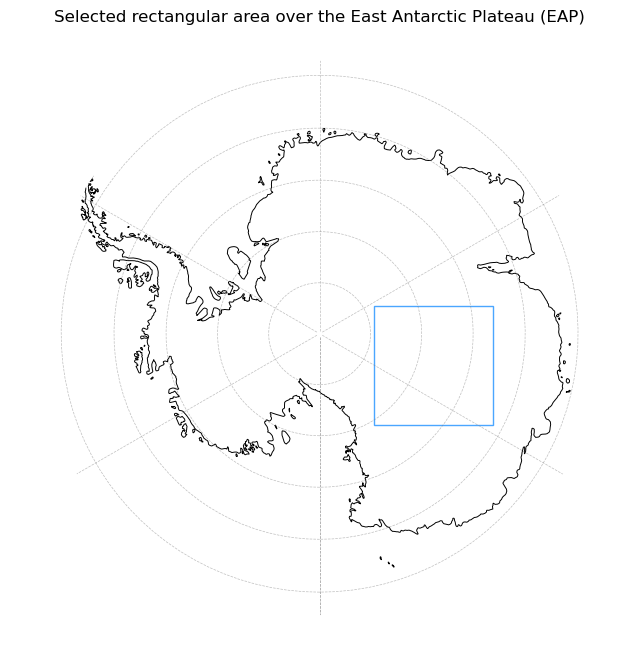

In [6]:
# Show selected region
def plot_APS(dataset, dataset_values):
    """
    """
    plt.figure(figsize = (8, 8))
    
    # Projection: target map; north is aligned with Greenwich (longitude), centred at South Pole
    ax = plt.subplot(projection = ccrs.Stereographic(central_longitude = 0., central_latitude = -90.))
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

    # set up a Cartopy coordinate reference system for the data (rotated pole as described above)
    data_crs = ccrs.Stereographic(central_longitude = 0., central_latitude = -90.)

    # Overlay of black coastline (built-in)
    ax.coastlines(resolution = '50m', linewidth = .7)
    # ax.stock_img()
    # set to draw_labels = True for lon lat
    ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = False,
                  linewidth = .5, color = 'gray', alpha = 0.5, linestyle = '--')
    
    ax.add_patch(patches.Rectangle((x1_min, x2_min), (x1_max - x1_min), (x2_max - x2_min), 
                                   fill = False, alpha = 0.8, color = "dodgerblue")) 

    # softcoded
    ax.set_title("Selected rectangular area over the East Antarctic Plateau (EAP)")
    
    # Circular boundry
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.45
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform = ax.transAxes)
    ax.axis('off')

    plt.show()
    
# Call plotting function
plot_APS(None, None)

### Prepare data for torch

We normalise both input variables to values in [0, 1].

In [7]:
# Normalise input coordinates with bounds of selected area
x1_norm = (df_EAIS.x1.values - x1_min)/(x1_max - x1_min)
x2_norm = (df_EAIS.x2.values - x2_min)/(x2_max - x2_min)

# transpose for shape: torch.Size([2238, 2])
train_x = torch.tensor(np.array([x1_norm, x2_norm]).T, dtype = torch.double)
# ToDo: Normalise y
train_y = torch.tensor(np.array(df_EAIS["smb"]), dtype = torch.double)

# for TEST: equally spaced grid
x1_mesh, x2_mesh = np.meshgrid(np.linspace(0, 1, 51), np.linspace(0, 1, 51))
test_x = torch.tensor(np.array([x1_mesh.reshape(-1), x2_mesh.reshape(-1)]).T, dtype = torch.double)

### Initialise GP model and likelihood

Since this is a simulated experiment, we assume access to the true smb function, based on data from the RACMO2.3p3 regional climate model (RCM). The data is provided on a grid, based on the rotated pole projection. We will be using the Antarctic Polar Stereographic projection (APS) for visualisations and in a subsequent problem setting with additional input data, since this is the dominant projection used in Antarctic Science. More information about APS can be read on [NSIDC webiste](https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection).

To optimise in the continous domain - where we can query anywhere - we use a GP to interpolate/infer a continous, smooth target function. For now, we treat this function as noise-less ground truth.

Because we are using the BoTorch package for Bayeisan Optimisation, we will use GPyTorch for Gaussian Processes. (see [GPyTorch’s documentation](https://docs.gpytorch.ai/en/stable/index.html))

In [8]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # Try other kernels
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 1.5))
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [9]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 80

# Train mode: Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.2)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood, exact inference
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    # Negative marginal log likelihood
    loss = - mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - NMLL Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/80 - NMLL Loss: 0.888   lengthscale: 0.693   noise: 0.693
Iter 2/80 - NMLL Loss: 0.797   lengthscale: 0.598   noise: 0.598
Iter 3/80 - NMLL Loss: 0.708   lengthscale: 0.514   noise: 0.513
Iter 4/80 - NMLL Loss: 0.621   lengthscale: 0.441   noise: 0.437
Iter 5/80 - NMLL Loss: 0.536   lengthscale: 0.381   noise: 0.371
Iter 6/80 - NMLL Loss: 0.455   lengthscale: 0.335   noise: 0.312
Iter 7/80 - NMLL Loss: 0.375   lengthscale: 0.305   noise: 0.262
Iter 8/80 - NMLL Loss: 0.294   lengthscale: 0.290   noise: 0.219
Iter 9/80 - NMLL Loss: 0.211   lengthscale: 0.288   noise: 0.182
Iter 10/80 - NMLL Loss: 0.125   lengthscale: 0.297   noise: 0.151
Iter 11/80 - NMLL Loss: 0.038   lengthscale: 0.314   noise: 0.125
Iter 12/80 - NMLL Loss: -0.050   lengthscale: 0.339   noise: 0.103
Iter 13/80 - NMLL Loss: -0.138   lengthscale: 0.370   noise: 0.085
Iter 14/80 - NMLL Loss: -0.224   lengthscale: 0.406   noise: 0.070
Iter 15/80 - NMLL Loss: -0.308   lengthscale: 0.443   noise: 0.057
Iter 16/80 - NM

Observations: Lengthscale parameter is reduced over the iterations for more local inference.

Because optimisation implementations are typically for minimisation, minimising the negative marginal log likelihood (NMLL) is equivalent to maximisation the likelihood. 

# 2D visualisation

We are slicing through the 3D surface at x = 0 to visualise the GP regression.

In [10]:
# Evaluation mode
model.eval()
likelihood.eval()

# Slice
# Small test for x1 == 0. Where first column (x1 = 0)
test_x_x0 = test_x[np.where(test_x[:,0] == 0.)]

f_preds_x0 = model(test_x_x0)
y_preds_x0 = likelihood(model(test_x_x0))

# Unpacking the predictions
f_mean_x0 = f_preds_x0.mean
f_var_x0 = f_preds_x0.variance
f_covar_x0 = f_preds_x0.covariance_matrix
# f_samples = f_preds.sample(sample_shape = torch.Size(100,))

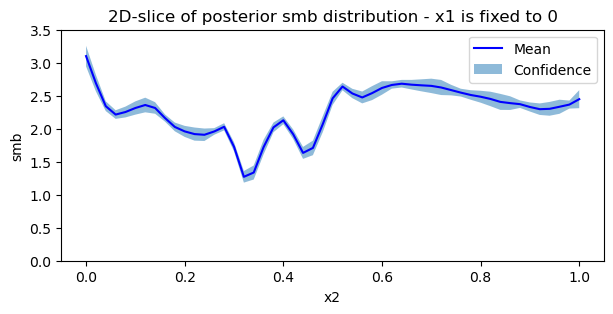

In [11]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize = (7, 3))

    # Get upper and lower confidence bounds
    lower, upper = y_preds_x0.confidence_region()
    
    # Plot predictive means as blue line
    # test_x_x0 is 2D so select second column only
    ax.plot(test_x_x0[:,1].numpy(), y_preds_x0.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x_x0[:,1].numpy(), lower.numpy(), upper.numpy(), alpha = 0.5)
    
    # observations are on different grid but just add 22 obs very close to x = 0 line
    # ax.plot(((df_EAIS.sort_values(by = ["x"], ascending = True)[0:22]["y"].values - y_min)/(y_max - y_min)), 
    #        df_EAIS.sort_values(by = ["x"], ascending = True)[0:22]["smb"].values, 'k*')
    
    ax.set_ylim([0, 3.5])
    ax.legend(['Mean', 'Confidence'])
    
    ax.set_title('2D-slice of posterior smb distribution - x1 is fixed to 0')
    ax.set_xlabel('x2')
    ax.set_ylabel('smb')
    
    # add additional datapoints from model

# Interpolate at smooth grid

In [12]:
# Ensure eval mode
model.eval()
likelihood.eval()

# Multivariate normal
f_preds = model(test_x)
# mean values
y_preds = likelihood(model(test_x))

# Unpacking the predictions
f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

# f_covar.shape
# plt.imshow(f_covar.detach().numpy(), norm = colors.Normalize(vmin = 0, vmax = 0.0001), cmap = "hot")

# 3D visualisation

In [13]:
df_smb_grid = pd.DataFrame(data = {'smb_mean': f_mean.detach().numpy(), 
                     'smb_var': f_var.detach().numpy(), 
                     'x1_norm': test_x[:,0].numpy(),
                     'x2_norm': test_x[:,1].numpy(),
                    })

# x1 need to be the columns (x-axis) (order!)
df_x1x2_matrix = df_smb_grid.pivot(index = 'x2_norm', columns = 'x1_norm', values = 'smb_mean')
x1_mesh, x2_mesh = np.meshgrid(df_x1x2_matrix.columns, df_x1x2_matrix.index)
# columns are the x1's
y_mesh = np.array(df_x1x2_matrix)

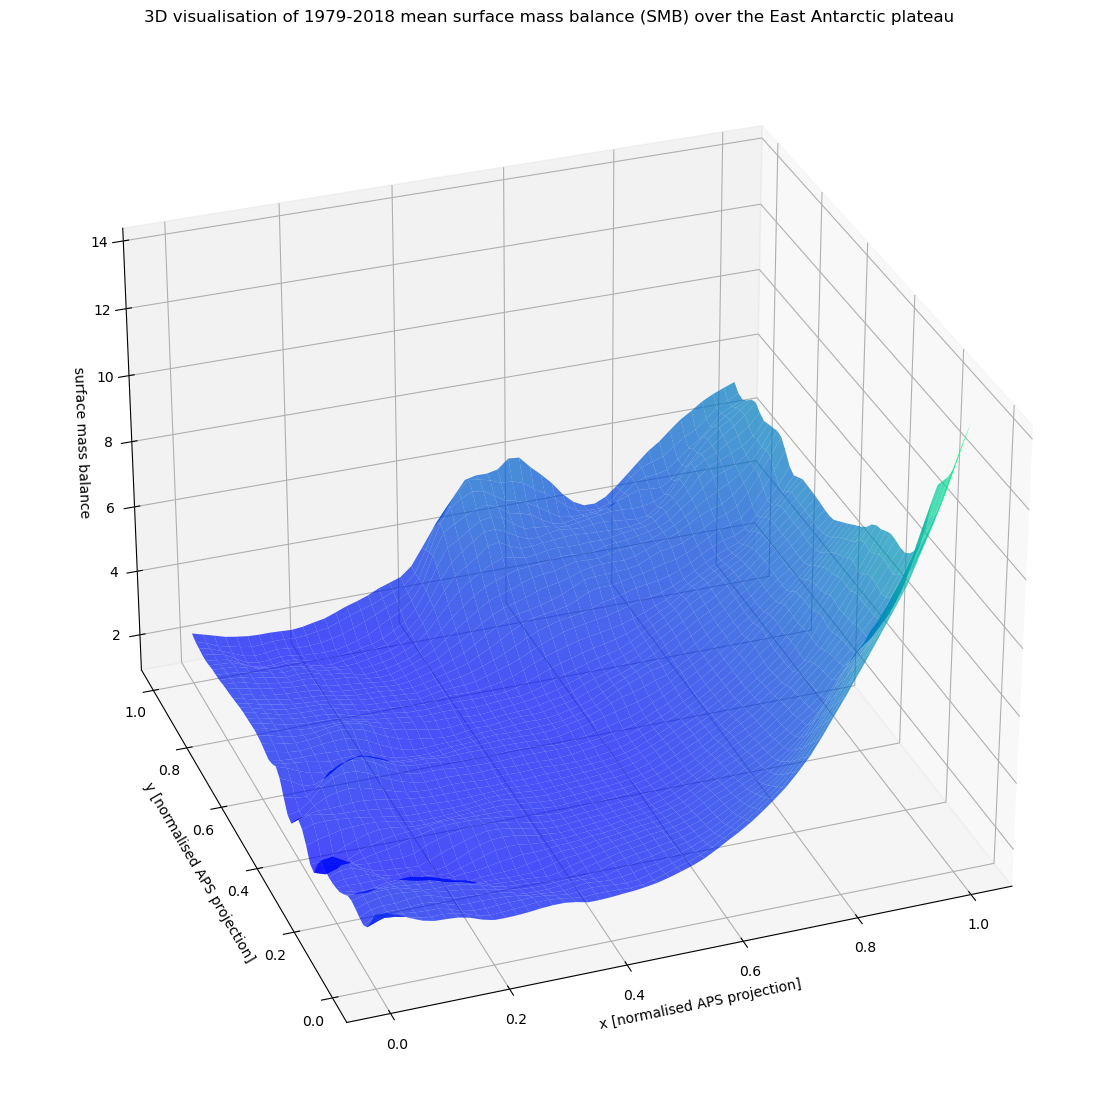

In [14]:
# 3D plot of mean smb
fig = plt.figure(figsize = (14, 14))
ax = plt.axes(projection = '3d') 
# Need to transpose the y-mesh to match
ax.plot_surface(x1_mesh, x2_mesh, y_mesh, rstride = 1, cstride = 1, cmap = 'winter', alpha = 0.7) 
# cmap = 'cubehelix'

ax.set_title("3D visualisation of 1979-2018 mean surface mass balance (SMB) over the East Antarctic plateau")
ax.set_xlabel('x [normalised APS projection]')
ax.set_ylabel('y [normalised APS projection]')
ax.set_zlabel('surface mass balance')

ax.view_init(elev = 30, azim = 250)

plt.show()

In [15]:
# Export
y_preds.loc.detach().numpy()

# create pandas DataFrame
APS_smb_df = pd.DataFrame(data = {'smb_smooth': y_preds.loc.detach().numpy(),
                          # first column
                          'x1': test_x.detach().numpy()[:,0],
                          # second column
                          'x2': test_x.detach().numpy()[:,1],
                                        }
                                )

# Kernels

ToDo: Try non-stationary kernels like Gibbs or `Remes, Sami, Markus Heinonen, and Samuel Kaski. "Non-stationary spectral kernels." Advances in neural information processing systems 30 (2017).`

- [Kernels in GpyTorch](https://docs.gpytorch.ai/en/stable/kernels.html)
    - [GridInterpolationKernel](https://docs.gpytorch.ai/en/stable/kernels.html#gridinterpolationkernel)
    - [SpectralMixtureKernel](https://docs.gpytorch.ai/en/stable/kernels.html#spectralmixturekernel)
- [Kernels in PyMC3](https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/GP-covariances.html)

# BO

In [16]:
# noise-free target function
def target_function(query_locations, model):
    """ Queries target function at query location(s) and returns value(s)
    Input: list of lists or torch.tensor and model
    """
    
    # placeholder: empty array
    results = np.empty(0)
    for x in query_locations:
        # Append only mean of kernel (neglect variance) to results array
        # reshape(1, -1): 1 for only one row of x, -1 for remaining dimensions (add explicit first dim)
        # * (-1) because we maximise
        results = np.append(results, (model(x.reshape(1, -1)).mean.detach().numpy() * (-1)))
    return(torch.tensor(results))

In [17]:
def generate_initial_data(n = 10):
    """ Generates randomly sampled set of initial data points
    Input: n
    """
    # Need unified dtypes
    train_x = torch.rand(n, 2, dtype = torch.float64) # n rows, 2 columns, sample between 0 and 1
    exact_obj = target_function(train_x, model).unsqueeze(-1)
    # max negative value is the min positive
    best_y = exact_obj.max()
    return train_x, exact_obj, best_y

In [18]:
# function wrapper
def get_next_point(queried_X, queried_y, best_queried_y, bounds, n_points = 1):
    surrogate_model = SingleTaskGP(queried_X, queried_y)
    # Pass in class liklihood for exact likelihood
    mll = ExactMarginalLogLikelihood(surrogate_model.likelihood, surrogate_model)
    fit_gpytorch_model(mll)
    
    EI = qExpectedImprovement(model = surrogate_model, best_f = best_queried_y)
    
    candidates, _ = optimize_acqf(
                                acq_function = EI,
                                bounds = bounds,
                                q = n_points, # number of candidates returned
        
                                # HYPERS
                                num_restarts = 200,
                                raw_samples = 256,
                                options = {"batch_limit" : 5, "maxiter" : 200} 
    )
    return candidates

### Create initial data set

In [19]:
n_initial = 15
torch.manual_seed(42)

# Call to generate initial data
queried_x, queried_y, best_queried_y = generate_initial_data(n = n_initial)

print(f"Best initial (negative) smb value: {best_queried_y}")

Best initial (negative) smb value: -1.8163363457805985


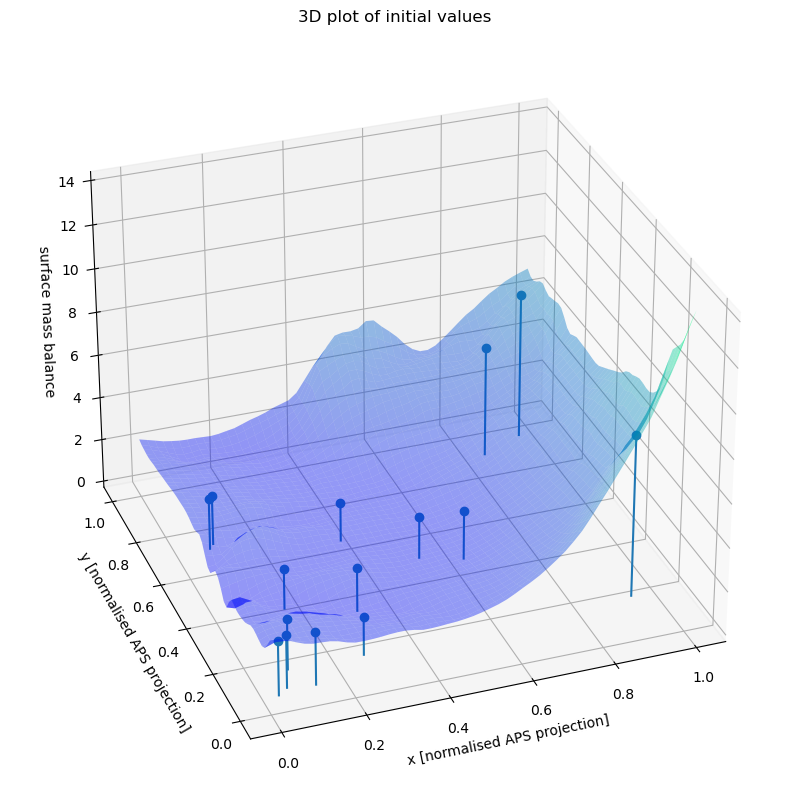

In [20]:
# 3D plot of mean smb
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection = '3d')

ax.plot_surface(x1_mesh, x2_mesh, y_mesh, rstride = 1, cstride = 1, cmap = 'winter', alpha = 0.4) 

ax.stem(queried_x[:,0].detach().numpy(), queried_x[:,1].detach().numpy(), queried_y[:,0].detach().numpy()*(-1), basefmt = " ") 

ax.set_title("3D plot of initial values")
ax.set_xlabel('x [normalised APS projection]')
ax.set_ylabel('y [normalised APS projection]')
ax.set_zlabel('surface mass balance')

ax.view_init(elev = 30, azim = 250)

plt.show()

In [21]:
# bounds for inputs: x1 and x2 have been min-max normalised
bounds = torch.tensor([[0.,0.],[1.,1.]])

n_runs = 10

for i in range(n_runs):
    print(f"Run number: {i}")
    new_candidate = get_next_point(queried_x, queried_y, best_queried_y, bounds, n_points = 1)
    new_result = target_function(new_candidate, model).unsqueeze(-1)
    print(f"New candidate: {new_candidate}")
    
    # Update
    queried_x = torch.cat([queried_x, new_candidate])
    queried_y = torch.cat([queried_y, new_result])
    
    # Check 
    best_queried_y = queried_y.max()
    # Maximisation of neg smb to minimise
    print(f"New best y (smb): {best_queried_y}")

Run number: 0
New candidate: tensor([[0.4675, 1.0000]])
New best y (smb): -1.8163363457805985
Run number: 1
New candidate: tensor([[0.2364, 0.5776]])
New best y (smb): -1.8139477431622026
Run number: 2
New candidate: tensor([[0.3920, 0.0090]])
New best y (smb): -1.8139477431622026
Run number: 3
New candidate: tensor([[0.5487, 0.6063]])
New best y (smb): -1.8139477431622026
Run number: 4
New candidate: tensor([[0.3252, 0.5499]])
New best y (smb): -1.8139477431622026
Run number: 5
New candidate: tensor([[0.3235, 0.1331]])
New best y (smb): -1.7432963344530776
Run number: 6
New candidate: tensor([[0.0000, 0.3828]])
New best y (smb): -1.7432963344530776
Run number: 7
New candidate: tensor([[0.3735, 0.1554]])
New best y (smb): -1.7432963344530776
Run number: 8
New candidate: tensor([[0.2785, 0.6623]])
New best y (smb): -1.7432963344530776
Run number: 9
New candidate: tensor([[0.1431, 0.5001]])
New best y (smb): -1.7432963344530776


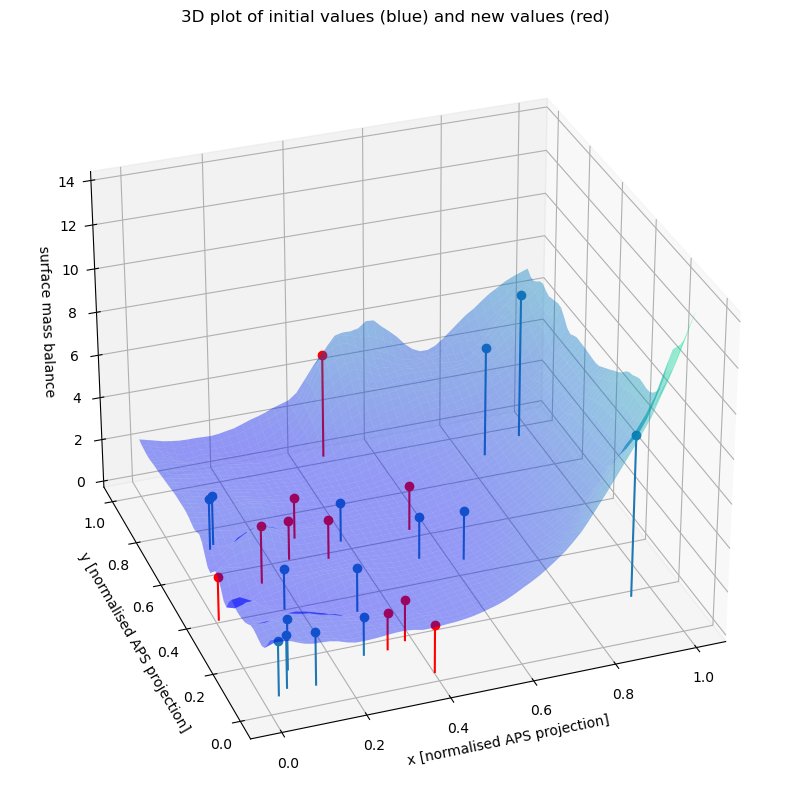

In [22]:
# 3D plot of mean smb
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection = '3d')

ax.plot_surface(x1_mesh, x2_mesh, y_mesh, rstride = 1, cstride = 1, cmap = 'winter', alpha = 0.4) 

ax.stem(queried_x[:n_initial,0].detach().numpy(), queried_x[:n_initial,1].detach().numpy(), queried_y[:n_initial,0].detach().numpy()*(-1), basefmt = " ")
ax.stem(queried_x[n_initial:,0].detach().numpy(), queried_x[n_initial:,1].detach().numpy(), queried_y[n_initial:,0].detach().numpy()*(-1), linefmt = 'r', markerfmt = 'ro', basefmt = " ")

ax.set_title("3D plot of initial values (blue) and new values (red)")
ax.set_xlabel('x [normalised APS projection]')
ax.set_ylabel('y [normalised APS projection]')
ax.set_zlabel('surface mass balance')

ax.view_init(elev = 30, azim = 250)

plt.show()

## References

[APA citation style]

- van Dalum, C., van de Berg, W. J., & van den Broeke, M. (2022, May). Antarctic surface climate in RACMO2. 3p3. In EGU General Assembly Conference Abstracts (pp. EGU22-12543).

## Versions

In [23]:
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.10.0

cartopy   : 0.21.1
pyproj    : 3.4.1
matplotlib: 3.6.3
pandas    : 1.5.3
watermark : 2.3.1
numpy     : 1.23.5
xarray    : 2022.11.0
gpytorch  : 1.9.1
shapely   : 2.0.1
GPy       : 1.10.0
torch     : 1.13.1

